In [1]:
# Jupyter notebook for analyzing DOGAMI data, see Scott Tse's emergence-response notebook at
# https://github.com/hackoregon/emergency-response/blob/analytics/notebooks/census_eda_geo.ipynb
# NOTE: Don't need all of these!
# Import modules included in "kitchen-sink"
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import gdal
import pandas as pd
import psycopg2
import seaborn as sns
from shapely.geometry import Polygon
import sys
# Import modules NOT included in "kitchen-sink", not sure about osgeo...
from dotenv import load_dotenv, find_dotenv
import geoplot as gplt
from osgeo import osr, ogr
from pyproj import Geod  # not sure if this is in kitchen-sink or not...
#import rasterio
from rasterstats import zonal_stats

%matplotlib inline

F.D. Pearce, 04/16/18

Notebook for computing statistics on raster pixel values contained within a geometry (shape) file

In [2]:
# Define ALL parameters in dictionary (convert to json config file!)
params = {
    'raster': {
        'root': './CSZ_M9p0_',
        'names': ['pgv_site', 'PGD_landslide_dry', 'PGD_landslide_wet', 'PGD_liquefaction_wet'],
        'ext': '.tif'
    },
    'geometry': {
        'from_postgis': {
            'query': {
                'table_name': 'neighborhood_units',
                'select_cols': 'nuid',
                'geometry_col': 'wkb_geometry',
                'epsg_code': 4326
            }
        }
    },
    'zonal_stats': {
        'layer': 1,
        'stats': ['count', 'min', 'max', 'mean', 'std']
        
    },
    'stats_classification': {
        'stats_to_class': ['min', 'max', 'mean'],
        'pgv_site': {
            'levels': [-9999, 0.1, 1.1, 3.4, 8.1, 16, 31, 60, 116, 9999],
            'level_labels': ['I', 'II-III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X'],
            'class_name': 'Modified Mercalli Intensity',
            'class_tag': 'MMI'
        },
        'PGD_landslide_dry': {
          'levels': [-9999, 0, 10, 30, 100, 9999],
          'level_labels': ['None', 'Low', 'Moderate', 'High', 'Very High'],
          'class_name': 'Landslide Intensity (Dry)',
          'class_tag': 'DI'
        },
        'PGD_landslide_wet': {
          'levels': [-9999, 0, 10, 30, 100, 9999],
          'level_labels': ['None', 'Low', 'Moderate', 'High', 'Very High'],
          'class_name': 'Landslide Intensity (Wet)',
          'class_tag': 'DI'
        },
        'PGD_liquefaction_wet': {
          'levels': [-9999, 0, 10, 30, 100, 9999],
          'level_labels': ['None', 'Low', 'Moderate', 'High', 'Very High'],
          'class_name': 'Liquefaction Intensity (Wet)',
          'class_tag': 'DI'
        }
    },
    'write_csv': {
        'name': "./DOGAMI_neighborhoodunits_raster_stats.csv"
    }
}

In [3]:
# Functions for obtaining geopandas dataframe containing geometry column from either
# 1) a local file (e.g. .dba file) or 2) interacting with PostGres database
def pgconnect():
    """Establish connection to PostGres database using the parameters specified in .env file.
    First, walk root diretory to find and load .env file w/ PostGres variables defining database, 
    user, host, password, and port variables.
    Then, return connection to database from psycopg2.connect
    """
    try:
        load_dotenv(find_dotenv())
        conn = psycopg2.connect(database=os.environ.get("PG_DATABASE"), user=os.environ.get("PG_USER"), 
                            password = os.environ.get("PG_PASSWORD"), 
                            host=os.environ.get("PG_HOST"), port=os.environ.get("PG_PORT"))
        print("Opened database successfully\n")
        return conn
    except psycopg2.Error as e:
        print("I am unable to connect to the database\n")
        print(e)
        print(e.pgcode)
        print(e.pgerror)
        print(traceback.format_exc())
        return None

def get_query_string(table_name, select_cols, geometry_col, epsg_code):
    """Build query string from parameter inputs defining table name, all the columns
    to select, select_cols, the column that defines the geometry, geometry_col, and
    the epsg code that defines the ellipsoid.
    """
    query_string = 'SELECT ' + select_cols + ', ' + \
            'ST_TRANSFORM({}, {}) AS geometry'.format(geometry_col, epsg_code)
    return query_string + ' FROM {}'.format(table_name)
    
    
def get_geometry_from_postgis(postgis_params):
    '''
    This function takes a dictionary containing parameters for building a SQL query,
    as defined in get_query_string, then connects to a postgis db, selects the 
    data specified in the query, and finally returns a geodataframe with a single
    column named geometry that contains shape data.
    '''
    query_string = get_query_string(**postgis_params['query'])
    conn = pgconnect()
    #cur = conn.cursor()
    print("SQL QUERY = "+query_string+'\r\n')
    try:
        geo_df = gpd.GeoDataFrame.from_postgis(
            query_string, 
            conn, 
            geom_col='geometry', 
            crs={'init': u'epsg:{}'.format(postgis_params['query']['epsg_code'])}, 
            coerce_float=False
        )
        return geo_df
    except Exception as e:
        print(e)
    finally:
        conn.close()
        
def get_geometry_from_file(name, geom_col='geometry'):
    """Import geometry from a file using geopandas.read_file
    Returns only the geometry column!
    """
    gdf = gpd.read_file(name)
    #print(type(gdf))
    return gdf

def calc_square_lonlat(lon_lat, xy_offset):
    """Calculate the longitude and latitude corresponding to the upper-right and lower-left
    corners of a square box centered on lat_lon, with a width of 2*xy_offset. 
    xy_offset MUST be in meters. Uses WGS84 (epsg=4326) ellipsoid.
    """
    az = [45, 225]
    lon = 2*[lon_lat[0]]
    lat = 2*[lon_lat[1]]
    mag = 2*[np.sqrt(2)*xy_offset]
    g = Geod(ellps='WGS84')
    rl_lon, tb_lat, _ = g.fwd(lon, lat, az, mag)
    return (rl_lon, tb_lat)

def calc_square_polygon(lon_lat, xy_offset):
    """Calculate polygon defining square box centered on lon, lat (decimal degrees)
    with a width of 2*xy_offset (meters).
    """
    rl_lon, tb_lat = calc_square_lonlat(lon_lat, xy_offset)
    poly = [Polygon((
            (rl_lon[0], tb_lat[0]),
            (rl_lon[0], tb_lat[1]),
            (rl_lon[1], tb_lat[1]),
            (rl_lon[1], tb_lat[0])
    ))]
    return poly

def get_geometry_from_point(lon_lat, xy_offset, xy_units="m"):
    """Returns a geodataframe containing a single geometry column that
    defines a square box centered on a point, specified as a lat, lon pair,
    The input parameter xy_offset defines the box half-width 
    1) Calculate the top-right corner and bottom-left corner of square box
    centered on lon_lat, using the WGS84 ellipsoid.
    2) Use the lon, lat of each corner to build a rectangular 
    polygon using shapely Polygon.
    3) Convert polygon to pandas geodataframe, set coordinate reference to 
    epsg 4326 (equivalent to WGS84).
    """
    if xy_units == "m":
        poly = get_square_polygon(lon_lat, xy_offset)
        # Build geodataframe with one row, column
        gdf = gpd.GeoDataFrame(poly, columns=['geometry'], geometry='geometry')
        gdf.crs = {'init' :'epsg:4326'}
        return gdf
    else:
        print("Error: input xy_offset MUST be in meters!!!")

def get_geodf_geometry(**kwargs):
    """Import geometry either from point and size, a file, or from postgis db
    """
    if 'from_point' in kwargs:
        return get_geometry_from_point(**kwargs['from_point'])
    elif 'from_file' in kwargs:
        return get_geometry_from_file(**kwargs['from_file'])
    elif 'from_postgis' in kwargs:
        return get_geometry_from_postgis(kwargs['from_postgis'])

In [4]:
# Functions for manipulating geoshapes and raster files
def get_gdfcrs_epsg(gdf):
    """Return integer EPSG code corresponding to Coordinate Reference
    used in input geodataframe, gdf. Attribute gdf.crs must contain
    a dict with key = 'init' that contains a string starting with 'epsg',
    followed by a colon, followed by an integer as a string.
    """
    try:
        dfepsg = gdf.crs['init'].split(':')
        if dfepsg[0] == 'epsg':
            return int(dfepsg[1])
    except:
        print('Error: geodataframe crs = {}, unrecognized EPSG integer'.format(gdf.crs['init']))

def get_raster_info_srs(raster_file, print_info=True):
    """Print information about raster file, and return its
    spatial reference system using gdal.
    """
    if print_info:
        try:
            print(gdal.Info(raster_file))
        except:
            print("Error reading info from raster file = {}".format(raster_file))
    try:
        raster = gdal.Open(raster_file)
    except:
        print("Error opening raster file = {}".format(raster_file))
    else:
        raster_srs = osr.SpatialReference()
        raster_srs.ImportFromWkt(raster.GetProjection())
        return raster_srs

def transform_polygons_from_srsinp_to_srsout(geom_col, srs_out):
    """Transform list of georeferenced polygon geometries from geopandas
    dataframe geometry column, geom_col, to the desired output Spatial Reference, srs_out.
    The input geometry column, geom_col, MUST have a valid epsg code defining its Spatial 
    Reference (SRS)."""
    # Define input spatial reference using epsg code from gdf
    srs_inp = ogr.osr.SpatialReference()
    srs_inp.ImportFromEPSG(get_gdfcrs_epsg(geom_col))
    poly_out = []
    # Define list of polygons in transformed spatial reference
    for g in geom_col:
        # If MultiPolygon, then assume it contains only one Polygon
        if g.type == 'MultiPolygon':
            poly = ogr.CreateGeometryFromWkt(g.geoms[0].wkt)
        elif g.type == 'Polygon':
            # Need to test this
            poly = ogr.CreateGeometryFromWkt(g.wkt)
        else:
            print("Error: geometry = {}, MUST be Polygon or MultiPolygon".format(g.type))
        poly.AssignSpatialReference(srs_inp)
        # Transform point co-ordinates so that they are in same projection as raster 
        poly.Transform(osr.CoordinateTransformation(srs_inp, srs_out))
        poly_out.append(poly.ExportToWkt())
    return poly_out

In [5]:
# Functions for computing raster statistics
def get_raster_stats_df(geom_ras, df_index, raster_file, raster_name, **kwargs):
    """Compute raster statistics for input geometry and raster file.
    Return results in dataframe
    """
    geomstats = zonal_stats(geom_ras, raster_file, **kwargs)
    df_gs = pd.DataFrame(geomstats, index=df_index)
    df_gs.rename(columns={co: raster_name+'_'+co for co in df_gs.columns}, inplace=True)
    return df_gs

# Functions for classifying raster statistics
def get_stats_classification(gdf, **kwargs):
    """Classify raster statistics using specified parameters in kwargs"""
    raster_names = [rn for rn in kwargs.keys() if rn != "stats_to_class"]
    for rn in raster_names:
        stats_to_class = [rn+'_'+sc for sc in kwargs['stats_to_class']]
        levels = kwargs[rn]['levels']
        labels = kwargs[rn]['level_labels']
        ctag = '_' + kwargs[rn]['class_tag']
        for s2c in stats_to_class:
            try:
                gdf[s2c+ctag] = pd.cut(gdf[s2c], levels, right=True, labels=labels)
            except KeyError:
                print("Key Error exception occurred for raster stat key = {}".format(s2c))
            except Exception as e:
                print("A non-key error exception occurred: {}".format(e))
    return gdf

In [6]:
#help(gpd.read_file)

In [7]:
# Step 1) Select geometry column either from Postgis db (implemented), or
# from shapefile (not yet implemented).  In eithe case, make sure geometry
# has a valid epsg Spatial reference assigned to it, such as 4326 (lon/lat)
# For a Postgis-derived geometry, this is done on the db-side using ST_TRANSFORM
# Note a copy of the original geopandas dataframe is made to preserve the dataframe
# obtained from postgis for debugging :-)
gdf = get_geodf_geometry(**params['geometry'])
gdf_merge = gdf.copy()
type(gdf_merge)
#gdf.info()
gdf_merge.info()
print(gdf['geometry'][0].type)
print(gdf['geometry'].crs)

#gdf = get_geometry_from_file("./Data/DisasterNeighborhoods/RLIS_ST_clips_pdx_final.dbf")
#gdf_shape = gpd.read_file("./Data/DisasterNeighborhoods/RLIS_ST_clips_pdx_final.dbf")
#gdf_shape.info()
#print(gdf_shape['geometry'][0].type)
#print(gdf_shape['geometry'].crs)

Opened database successfully

SQL QUERY = SELECT nuid, ST_TRANSFORM(wkb_geometry, 4326) AS geometry FROM neighborhood_units

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 2 columns):
nuid        876 non-null int64
geometry    876 non-null object
dtypes: int64(1), object(1)
memory usage: 13.8+ KB
MultiPolygon
{'init': 'epsg:4326'}


In [8]:
# Steps 2 through 5 are repeated for each raster file
# the results for each raster are appended to gdf_merge
for raster_name in params['raster']['names']:
    # Step 2) Print info about tif file (optional) and get its spatial reference info
    raster_file = params['raster']['root'] + raster_name + params['raster']['ext']
    print("Computing statistics for raster file = {}".format(raster_file))
    srs_raster = get_raster_info_srs(raster_file, print_info=False)

    # Step 3) Generate a list of polygons transformed from the srs used in the 
    # input geodataframe, gdf, to the srs used in the raster file, srs_raster
    geom_ras = transform_polygons_from_srsinp_to_srsout(gdf_merge['geometry'], srs_raster)
    #print("# of rows in transformed geometry ({}) and geodataframe ({}) should be equal!".format(
    #        len(geom_ras), len(gdf)
    #))

    # Step 4) Use rasterstats to compute analytics on pixel values within specified geometry, 
    # MUST be polygon or multipolygon and transformed to srs_raster!
    # Add stats from pixel values into geodataframe that defines geometry
    df_gs = get_raster_stats_df(geom_ras, gdf_merge.index, raster_file, raster_name, 
                                **params['zonal_stats']
    )
    
    # Step 5) Aggregate the statistics from each raster into a final merged geodataframe
    gdf_merge = gdf_merge.join(df_gs)

Computing statistics for raster file = ./CSZ_M9p0_pgv_site.tif


/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/main.py:145: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)
/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/main.py:165: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  np.issubdtype(fsrc.array.dtype, float)


Computing statistics for raster file = ./CSZ_M9p0_PGD_landslide_dry.tif


/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/rasterstats/io.py:294: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


Computing statistics for raster file = ./CSZ_M9p0_PGD_landslide_wet.tif
Computing statistics for raster file = ./CSZ_M9p0_PGD_liquefaction_wet.tif


In [9]:
gdf_merge.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 22 columns):
nuid                          876 non-null int64
geometry                      876 non-null object
pgv_site_count                876 non-null int64
pgv_site_max                  876 non-null float64
pgv_site_mean                 876 non-null float64
pgv_site_min                  876 non-null float64
pgv_site_std                  876 non-null float64
PGD_landslide_dry_count       876 non-null int64
PGD_landslide_dry_max         876 non-null float64
PGD_landslide_dry_mean        876 non-null float64
PGD_landslide_dry_min         876 non-null float64
PGD_landslide_dry_std         876 non-null float64
PGD_landslide_wet_count       876 non-null int64
PGD_landslide_wet_max         876 non-null float64
PGD_landslide_wet_mean        876 non-null float64
PGD_landslide_wet_min         876 non-null float64
PGD_landslide_wet_std         876 non-null float64
PGD_liquefaction_wet_count   

In [10]:
gdf_merge['PGD_landslide_dry_count']

0        377267
1         88985
2         45771
3        100965
4         84952
5        265919
6         58271
7        232278
8         87795
9        148959
10       108957
11       223566
12        70334
13       178780
14        86287
15       135061
16        51401
17        73600
18        73584
19        93061
20       164400
21       197726
22       133790
23       240737
24       240284
25        82678
26       161960
27       344087
28       849745
29        73597
         ...   
846       43648
847      654120
848    10377117
849     6967467
850      133294
851     3926059
852     4429579
853     4364742
854     3463126
855      470926
856      767578
857      570767
858      888366
859      676081
860      736631
861       80482
862      133026
863      183521
864      756460
865       69392
866      103615
867      721074
868     6712776
869     4807869
870    16218453
871    22465672
872     5101747
873     4030346
874    16421683
875    21955550
Name: PGD_landslide_dry_

In [11]:
# Step 6) Classify a subset of the geometry statistics, converting the calculated
# stat in pixel values to a label describing the stats intensity bin
if 'stats_classification' in params:
    gdf_merge_class = get_stats_classification(gdf_merge, **params['stats_classification'])
gdf_merge_class.info()
#print(gdf_merge_class[['PGD_landslide_dry_max', 'PGD_landslide_dry_max_DI']])

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 34 columns):
nuid                            876 non-null int64
geometry                        876 non-null object
pgv_site_count                  876 non-null int64
pgv_site_max                    876 non-null float64
pgv_site_mean                   876 non-null float64
pgv_site_min                    876 non-null float64
pgv_site_std                    876 non-null float64
PGD_landslide_dry_count         876 non-null int64
PGD_landslide_dry_max           876 non-null float64
PGD_landslide_dry_mean          876 non-null float64
PGD_landslide_dry_min           876 non-null float64
PGD_landslide_dry_std           876 non-null float64
PGD_landslide_wet_count         876 non-null int64
PGD_landslide_wet_max           876 non-null float64
PGD_landslide_wet_mean          876 non-null float64
PGD_landslide_wet_min           876 non-null float64
PGD_landslide_wet_std           876 non-null flo

In [12]:
# Step 7) Option to write results to csv file
if 'write_csv' in params:
    gdf_merge_class.to_csv(params['write_csv']['name'])

### Testing

In [114]:
#If geometry was build from point, then check the length of square to make
# sure it matches the input length, xy_offset
if 'from_point' in params['geometry']:
    poly_coords = list(gdf_merge_class['geometry'][0].exterior.coords)
    print(poly_coords)
    g = Geod(ellps='WGS84')
    az12,az21,dist = g.inv(poly_coords[0][0], poly_coords[0][1], poly_coords[1][0], poly_coords[1][1])
    print("The returned azimuth, {}, should point N-S (i.e. 0 or 180)".format(az12))
    print("The returned distance, {}, should be equal to 2*xy_offset, {}, within roundoff."
          .format(dist, 2*params['geometry']['from_point']['xy_offset']
    ))

[(-122.62246806545195, 45.461206507654005), (-122.62246806545195, 45.45580794713887), (-122.63013918411258, 45.45580794713887), (-122.63013918411258, 45.461206507654005), (-122.62246806545195, 45.461206507654005)]
The returned azimuth, -180.0, should point N-S (i.e. 0 or 180)
The returned distance, 599.9999990960112, should be equal to 2*xy_offset, 600, within roundoff.


### Plotting

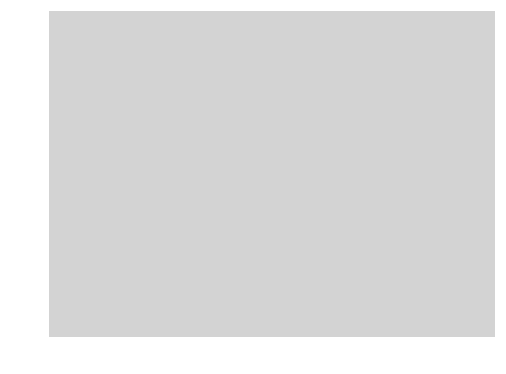

In [76]:
# For geometry input from point, this plot should be a rectangle, not
# necessarily a square do to map projection...
gplt.polyplot(gdf_merge_class.geometry,
                   facecolor='lightgray', edgecolor='gray', linewidth=0)

/home/jupyter/.conda/envs/jupyter/lib/python3.6/site-packages/pysal/esda/mapclassify.py:902: RuntimeWarning: invalid value encountered in double_scalars
  cuts = np.arange(min_y + width, max_y + width, width)


ValueError: arange: cannot compute length

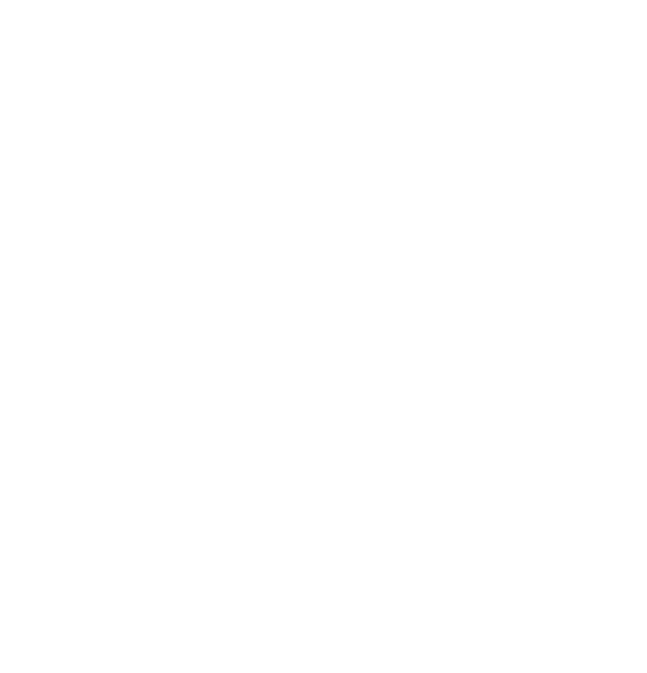

In [71]:
# Make a map showing distribution of df column, col2plot_y
#col2plot_y = 'casualties_avetotal'
#col2plot_y = 'buildingloss'
#col2plot_y = 'buildingloss_ratio'
col2plot_y = 'pgv_site_max'

gplt.choropleth(gdf_merge,
                hue=gdf_merge[col2plot_y],  # Display data, passed as a Series
                projection=gplt.crs.AlbersEqualArea(),
                cmap='Purples',
                linewidth=0.5,
                edgecolor='black',
                k=5,
                legend=True,
                scheme='equal_interval',
                figsize=(12, 12)
)
plt.title("{}".format(col2plot_y), fontsize=24)